In [121]:
import os
import pickle
import numpy as np
import pandas as pd
import numpy.matlib
import pickle

from matplotlib import pyplot as plt
from scipy import linalg, sparse, stats
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

Initialize an English dictionary to filter words from the GloVe dataset. The GloVe dataset used has parsed over Wikipedia and thus contains a lot of noise. This is filtered using a spell check

In [122]:
import hunspell
spellchecker = hunspell.HunSpell('../data/hunspell/en_US.dic',
                                 '../data/hunspell/en_US.aff')

In [123]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'
TEXTURE_PATH = "/raid/data/datasets/broden1_384/c_texture.csv"

In [124]:
textures = pd.read_csv(TEXTURE_PATH, index_col = 0)
texture_list = list(textures['name'])

Read the concept activation vectors from the Broden dataset as a dictionary

In [125]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (400 000 x 300). The dataset contains about 400K words. All the words are run through a spell checker, if the word is not present in the English dictionary which was used, the word is removed. In total about 280000 words are removed from the GloVe dataset

In [126]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
    glove_words = list(embedding_dict.keys())
    
else:
    embedding_dict = {}
    glove_words = []
    glove_embedding_matrix = np.zeros((400000, 300))

    # parse through the GloVe data
    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f)):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32').reshape(1,-1)
            
            # apply a spell check
            try:
                if spellchecker.spell(word):
                    embedding_dict[word] = vector
                    glove_embedding_matrix[i] = vector
                    glove_words.append(word)
            except:
                UnicodeEncodeError
                    
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # not all 400K rows are used as a certain amount of words are not used, 
    # thus the unused rows are removed from the matrix
    glove_embedding_matrix = glove_embedding_matrix[:len(glove_words)]
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [127]:
# list all Broden concepts
all_broden_concepts = list(cavs_broden.keys())

# remove duplicates from concept list (e.g. mountain-s is stored when mountain and mountain-s are both in the dataset)
# and remove the textures from the concepts
no_dups_concepts = [c for c in all_broden_concepts if c +'-s' not in all_broden_concepts and c not in texture_list]

In [128]:
len(no_dups_concepts)

649

In [129]:
# create a matrix of all cavs
cav_matrix = np.zeros((len(no_dups_concepts), cavs_broden[no_dups_concepts[0]]['cav'].shape[1]))
for i in range(len(no_dups_concepts)):
    cav = cavs_broden[no_dups_concepts[i]]['cav']
    cav_matrix[i] = cav

# remove the '-s' from the concepts if present 
broden_concepts = [c[:-2] if c[-2:] == '-s' else c for c in no_dups_concepts]

In [130]:
cav_matrix.shape

(649, 2048)

Extract concepts which have a CAV and a correspondence in the GloVe data. The index is stored to remove the unavailable concepts from the CAV matrix

In [131]:
embedding_ix_concepts = [(idx, c) for idx, c in enumerate(broden_concepts) if c in embedding_dict.keys()]

# store the indices of concepts which are present in both datasets
embedding_idxs = [ix for ix, n in embedding_ix_concepts]
embedding_concepts = [c for ix, c in embedding_ix_concepts]

In [132]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  363


In [133]:
cavs_with_embedding = cav_matrix[embedding_idxs]

In [134]:
cavs_with_embedding.shape

(363, 2048)

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [135]:
embeddings_with_cav = np.zeros((len(embedding_idxs), 300))
for i in range(len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i]].reshape(1,-1)
    embeddings_with_cav[i] = word_vec

In [136]:
embeddings_with_cav.shape

(363, 300)

Create matrix with CAVs which do not have a matching word embedding

In [261]:
cav_no_glove = np.delete(cav_matrix, embedding_idxs, axis=0)
cav_no_glove_concepts = [conc for conc in broden_concepts if conc not in embedding_concepts]

Create matrix with GloVe embeddings which do not have a matching CAV

In [138]:
glove_no_cav = np.zeros((len(glove_words) - len(embedding_concepts), 300))
glove_no_cav_concept = []

idx = 0
for concpt in embedding_dict.keys():
    if concpt not in embedding_concepts:
        glove_no_cav_concept.append(concpt)
        concpt_vec = embedding_dict[concpt]
        glove_no_cav[idx] = concpt_vec
        idx +=1

# glove_no_cav_subset = glove_no_cav[:1000]

In [139]:
glove_no_cav.shape

(117964, 300)

Normalize all data to norm-1

In [140]:
glove_no_cav_norm = normalize(glove_no_cav, axis=1)
glove_norm = normalize(embeddings_with_cav,axis=1)

cavs_norm = normalize(cavs_with_embedding,axis=1)
cav_no_glove_norm = normalize(cav_no_glove, axis=1)

Find the nearest neighbors of the GloVe embeddings which do have correspondence with CAVs. These are used in the manifold alignment to preserve the structure of the GloVe data

In [144]:
knn = NearestNeighbors(10, n_jobs=5)
knn.fit(glove_no_cav_norm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=5, n_neighbors=10, p=2, radius=1.0)

Create a list of unique indices of the nearest neigbors to the GloVe embeddings which have a correspondence with a CAV

In [145]:
# takes about 3min to run
glove_neighbors = []
for k in tqdm(range(embeddings_with_cav.shape[0])):
    nn = knn.kneighbors(glove_norm[k,:].reshape(1,-1), return_distance=False)
    for n in nn.flatten():
        if n.item() not in glove_neighbors:
            glove_neighbors.append(n)

In [146]:
len(glove_neighbors)

2646

In [147]:
glove_no_cav_subset = glove_no_cav_norm[glove_neighbors]
glove_no_cav_subset_concept = [glove_no_cav_concept[n_n] for n_n in glove_neighbors]

Concatenate the data together, the first 373 rows have correspondence between the datasets

In [264]:
cavs_sorted = np.concatenate((cavs_norm, cav_no_glove_norm))
cavs_sorted_concept = embedding_concepts + cav_no_glove_concepts

glove_sorted = np.concatenate((glove_norm, glove_no_cav_subset))

In [149]:
cavs_sorted.shape

(649, 2048)

In [150]:
glove_sorted.shape

(3009, 300)

## Manifold alignment

In [151]:
def gen_eig(A, B, option, n_eig):
    """
    Extracts generalized eigenvalues for problem A * U = B * U * landa
    """
    
    
    n_eig = min(n_eig, np.linalg.matrix_rank(A), np.linalg.matrix_rank(B))
    
    B = (B + B.T) / 2
    R = B.shape[0]
    rango = np.linalg.matrix_rank(B)
    
    if rango == R:
        U = np.zeros((R, n_eig))
        D = np.zerose((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        for k in range(n_eig):
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option) #'a' are the eigenvectors in the matlab code
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            a = np.divide(a, np.sqrt(np.matmul(ab, a)))
            U[:,k] = a
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            dba = np.matmul(d, ba)
            A = A - np.matmul(dba, aTb)
        
        return U, D, n_eig
    
    else:
        d, v = sparse.linalg.eigs(B, rango)
        d = d.real
        v = v.real
        
        B = np.matmul(v.T, B)
        B = np.matmul(B, v)
        
        A = np.matmul(v.T, A)
        A = np.matmul(A, v)
        
        U2 = np.zeros((rango, n_eig))
        D = np.zeros((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        
        for k in range(n_eig):
            
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option)
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            aba = np.matmul(ab, a)
            a = np.divide(a, np.sqrt(aba))
            
            U2[:,k] = a.flatten()
        
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            
            dba = d * ba
            A = A - np.matmul(dba, aTb)
        
        U = np.matmul(v, U2)
        return U, D, n_eig

Transpose the matrices to column matrices

In [152]:
cavs_norm_col = cavs_norm.T
glove_norm_col = glove_norm.T

cavs_sorted_norm_col = cavs_sorted.T
glove_sorted_norm_col = glove_sorted.T

d1, n1 = cavs_sorted_norm_col.shape
d2, n2 = glove_sorted_norm_col.shape

In [153]:
n1

649

In [154]:
tot_samples = n1+n2
tot_samples

3658

As the data is normalized to norm 1, the multiplication of the matrix with its transpose should show 1s along the diagonal

In [155]:
#plt.imshow(np.matmul(cavs_sorted_norm_col.T, cavs_sorted_norm_col))

To perform manifold allignment the MatLab code from Devis Tuia is followed: https://github.com/dtuia/KEMA/blob/master/general_routine/KMA.m

In [156]:
n_samples = len(embedding_concepts)
MU = 0.95
LAMBDA = 0.5

Compute the adjacency matrices for both the CAV and GloVe data

In [157]:
n_neighbors = 15
cav_knn_graph = kneighbors_graph(cavs_sorted, n_neighbors, mode = 'connectivity')
cav_knn_graph = cav_knn_graph.toarray()

In [158]:
glove_knn_graph = kneighbors_graph(glove_sorted, n_neighbors, mode = 'connectivity', n_jobs = 10)
glove_knn_graph = glove_knn_graph.toarray()

In [159]:
W = linalg.block_diag(cav_knn_graph, glove_knn_graph)

In [160]:
#plt.imshow(W)

Similarity matrix (Ws) encodes the samples belonging to the same class. In this research, there is a pairwise connections, every CAV only has a single match with a word embedding. This relation can be captured by the identity matrix. <br> The corresponding diagonal row sum matrix (Ds) results from summing Ws along the rows and converting the sums to a diagonal matrix.

In [161]:
Ws = np.zeros((n1+n2, n1+n2))

Ws1 = np.eye(n1)
Ws2 = np.eye(n2)
Ws3 = np.eye(n_samples)

Ws[:n1, :n1] = Ws1
Ws[n1:, n1:] = Ws2
Ws[n1:(n1+n_samples), :n_samples] = Ws3
Ws[:n_samples, n1:(n1+n_samples)] = Ws3

Ws = Ws + np.eye(Ws.shape[0])

# the identity matrices of Ws3 are not plotted on the imshow, but when plotting the right coordinates it does appear
#plt.imshow(Ws)
#plt.imshow(Ws[:400, n1:n1+400])

# should be True
Ws[0, n1] == 1

True

The dissimilarity matrix (Wd) encodes which samples do not belong to the same class. This is important to capture, otherwise every sample will end in the same location (the origin) as this will capture the similarity between the samples. In this research it is assumed that every sample is dissimilar from every other sample except from itself.

In [162]:
Wd = np.ones((n1+n2, n1+n2))
np.fill_diagonal(Wd, 0)

Wd1 = np.ones((n_samples, n_samples))
np.fill_diagonal(Wd1, 0)

Wd[:n_samples, n1:(n1+n_samples)] = Wd1
Wd[n1:(n1+n_samples), :n_samples] = Wd1

Wd = Wd + np.eye(Wd.shape[0])

#plt.imshow(Wd[:400, n1:n1+400])
#plt.imshow(Wd)

Wd[n1:n1+5, :5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Normalize the data

In [163]:
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

Extract the diagionals from the matrices

In [164]:
Dd = np.diag(np.sum(Wd, axis=1))
Ds = np.diag(np.sum(Ws, axis = 1))
D = np.diag(np.sum(W, axis=1))

In [165]:
D.shape

(3658, 3658)

Create the Laplacians which represent the structure of the data

In [166]:
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity

L = D - W # Laplacian topology/geometry

In [167]:
A = ((1 - MU) * L + MU * Ls) + LAMBDA * np.eye(Ls.shape[0])
B = Ld

In [168]:
L.shape

(3658, 3658)

In [169]:
A.shape

(3658, 3658)

In [170]:
kernel_cav = np.matmul(cavs_sorted_norm_col.T, cavs_sorted_norm_col)
# #the kernel should have a diagonal of 1s
#plt.imshow(kernel_cav)

In [171]:
kernel_glove = np.matmul(glove_sorted_norm_col.T, glove_sorted_norm_col)
#plt.imshow(kernel_glove)

In [172]:
K = linalg.block_diag(kernel_cav, kernel_glove)

In [173]:
# plt.imshow(K)

In [174]:
KA = np.matmul(K,A)
KB = np.matmul(K,B)

KAK = np.matmul(KA, K)
KBK = np.matmul(KB, K)

In [175]:
# plt.imshow(KBK)

Solve the generalized eigenvalue decomposition

In [176]:
ALPHA, LAMBDA,n_eig = gen_eig(KAK, KBK, 'LM', 8)

Sort the eigenvalues and vectors

In [177]:
lambda_idxs = np.diag(LAMBDA).argsort()
LAMBDA = np.sort(np.diag(LAMBDA))
LAMBDA = LAMBDA.reshape(LAMBDA.shape[0],1)

In [178]:
LAMBDA

array([[0.65647762],
       [0.65783963],
       [0.66088881],
       [0.66425565],
       [0.66514578],
       [0.66988037],
       [0.6753882 ],
       [0.82619852]])

In [179]:
ALPHA = ALPHA[:, lambda_idxs]

Divide the eigenvectors over the 2 datasets

In [180]:
E1 = ALPHA[:n1, :] #eigenvectors for the first dataset (CAV)
E2 = ALPHA[n1:, :] #eigenvectors for the second dataset (GloVe)

Rotate axis is necessary

In [181]:
sourceXpInv = (-1 * np.matmul(E1.T, kernel_cav)).T
sourceXp = np.matmul(E1.T, kernel_cav).T
targetXp = np.matmul(E2.T, kernel_glove).T

In [182]:
sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

In [183]:
sourceXpInv.shape

(649, 8)

In [184]:
ErrRec = np.zeros((n1, ALPHA.shape[1]))
ErrRecInv = np.zeros((n1, ALPHA.shape[1]))

In [185]:
m1 = np.zeros((n1, ALPHA.shape[1]))
m1inv = np.zeros((n1, ALPHA.shape[1]))
m2 = np.zeros((n1, ALPHA.shape[1]))

In [186]:
cls = np.arange(n1).reshape(-1,1)

Compare the error of the inverted eigenvectors and the normal eigenvectors

In [187]:
for j in range(ALPHA.shape[1]):
    for i in range(n1):
        m1inv[i,j] = np.mean(sourceXpInv[i, j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[i, j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[i, j])
        #print('m2: ', m2)
        
        ErrRec[i,j] = np.square(np.power(np.mean(sourceXp[i, j]) - np.mean(targetXp[i, j]), 2))
        
        ErrRecInv[i,j] = np.square(np.power(np.mean(sourceXpInv[i, j]) - np.mean(targetXp[i, j]),2))
        


In [188]:
Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)

In [189]:
Sc

array([ True,  True,  True,  True,  True,  True,  True,  True])

Invert axis if necessary

In [190]:
ALPHA[:n1, Sc] = ALPHA[:n1, Sc] * -1

In [191]:
NF = 100

In [192]:
nVectLin = min(NF, np.linalg.matrix_rank(KBK))
nVectLin = min(nVectLin, np.linalg.matrix_rank(KAK))

Transform data

In [240]:
T1 = cavs_sorted_norm_col.shape[1]
T2 = glove_sorted_norm_col.shape[1]

for Nf in range(nVectLin):
    E1 = ALPHA[:n1, :Nf+1]
    E2 = ALPHA[n1:, :Nf+1]
    
    Phi1toF = np.matmul(E1.T, kernel_cav)
    Phi2toF = np.matmul(E2.T, kernel_glove)
    
    Phi1TtoF = np.matmul(E1.T, kernel_cav) #KT1?
    Phi2TtoF = np.matmul(E2.T, kernel_glove) #KT2?
    
    m1 = np.mean(Phi1toF.T, axis = 0)
    m2 = np.mean(Phi2toF.T, axis = 0)
    s1 = np.std(Phi1toF.T, axis = 0)
    s2 = np.std(Phi2toF.T, axis =0)
    
    #Phi1toF = stats.zscore(Phi1toF).T
    #Phi2toF = stats.zscore(Phi2toF).T
    
    Phi1TtoF = np.divide((Phi1TtoF.T - np.matlib.repmat(m1, T1, 1)), 
                         np.matlib.repmat(s1, T1, 1)).T
    
    Phi2TtoF = np.divide((Phi2TtoF.T - np.matlib.repmat(m2, T2 ,1)),
                         np.matlib.repmat(s2, T2, 1)).T

In [194]:
# Phi1TtoF_Lin = Phi1TtoF
# Phi2TtoF_Lin = Phi2TtoF

Phi1TtoF_Lin = scale(Phi1TtoF, axis=1)
Phi2TtoF_Lin = scale(Phi2TtoF, axis=1)

# Phi1TtoF_Lin = normalize(Phi1TtoF_Lin, axis=0)
# Phi2TtoF_Lin = normalize(Phi2TtoF_Lin, axis=0)


# Phi1TtoF_Lin = normalize(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = normalize(Phi2TtoF, axis = 0)

# Phi1TtoF_Lin = stats.zscore(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = stats.zscore(Phi2TtoF, axis = 0)


In [195]:
np.std(Phi2TtoF_Lin, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [196]:
Phi1TtoF_Lin.shape

(8, 649)

Text(0.2064805082680131, -2.947502469213531, 'canyons')

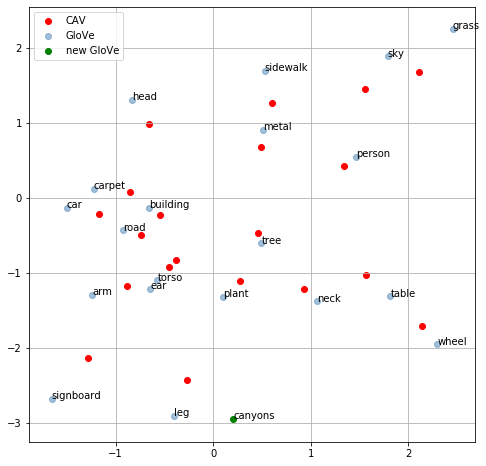

In [200]:
num_concepts = 20
new_glove = 1873 #

plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(Phi1TtoF_Lin[0,:num_concepts], Phi1TtoF_Lin[1,:num_concepts], label = 'CAV', color = 'red')
plt.scatter(Phi2TtoF_Lin[0,:num_concepts], Phi2TtoF_Lin[1,:num_concepts], label = 'GloVe', color = 'steelblue', alpha=0.5)
plt.scatter(Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples + new_glove], label = 'new GloVe', color='green')
#plt.xlim([-2.5,2.5])
#plt.ylim([-2.5, 2.5])


plt.legend()

for ii, txt in enumerate(embedding_concepts[:num_concepts]):
#     plt.annotate(txt, (Phi1TtoF_Lin[0,ii], Phi1TtoF_Lin[1,ii]))
    plt.annotate(txt, (Phi2TtoF_Lin[0,ii], Phi2TtoF_Lin[1,ii]))

plt.annotate(glove_no_cav_subset_concept[new_glove], (Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples+new_glove]))

In [198]:
for ix, d in enumerate(glove_no_cav_subset_concept):
    print(ix, d)

0 skies
1 bright
2 blue
3 horizon
4 darkness
5 dark
6 sun
7 lights
8 heavens
9 starry
10 trees
11 pine
12 oak
13 shrubs
14 planted
15 trunks
16 bark
17 garden
18 eucalyptus
19 shrub
20 buildings
21 built
22 construction
23 houses
24 constructed
25 structure
26 build
27 brick
28 demolished
29 structures
30 someone
31 man
32 anyone
33 woman
34 one
35 actually
36 persons
37 people
38 else
39 somebody
40 heads
41 assistant
42 chief
43 headed
44 director
45 deputy
46 chair
47 hand
48 then
49 former
50 legs
51 thigh
52 knee
53 ankle
54 injury
55 shoulder
56 wrist
57 groin
58 foot
59 elbow
60 buttocks
61 torsos
62 thighs
63 abdomen
64 limbs
65 pelvis
66 hips
67 forearm
68 extremities
69 tables
70 sit
71 sitting
72 room
73 dining
74 chairs
75 dinner
76 side
77 sat
78 place
79 arms
80 right
81 hands
82 finger
83 chest
84 roads
85 route
86 lane
87 along
88 intersection
89 roadway
90 junction
91 highways
92 trail
93 lanes
94 ears
95 eye
96 nose
97 throat
98 mouth
99 jaw
100 eyes
101 eardrum
102 t

1395 heavy
1396 manor
1397 castles
1398 fortress
1399 medieval
1400 château
1401 town
1402 situated
1403 rebuilt
1404 residence
1405 heiress
1406 loveless
1407 seeded
1408 peppermint
1409 seed
1410 7-5
1411 unseeded
1412 davenport
1413 6-3
1414 6-2
1415 altars
1416 basilica
1417 cathedral
1418 sacristy
1419 pews
1420 apse
1421 crucifix
1422 sacrificial
1423 nave
1424 pastures
1425 grazing
1426 graze
1427 meadow
1428 grassland
1429 grasslands
1430 pant
1431 pantsuits
1432 pinstriped
1433 pinstripe
1434 pantsuit
1435 sleeves
1436 chart
1437 charts
1438 peaked
1439 debuted
1440 peaking
1441 number-one
1442 charted
1443 charting
1444 airplay
1445 nurseries
1446 kindergarten
1447 rhyme
1448 preschool
1449 kindergartens
1450 rhymes
1451 daycare
1452 elementary
1453 decorations
1454 decorated
1455 decorative
1456 ornamentation
1457 ornament
1458 sculptural
1459 ornaments
1460 stucco
1461 architectural
1462 lobbies
1463 lobbying
1464 lobbyists
1465 capitol
1466 lobbied
1467 hotel
1468 banquet


2354 megalithic
2355 tumulus
2356 moated
2357 megaliths
2358 chelate
2359 fibulae
2360 polygonal
2361 necropolis
2362 dachas
2363 sanitarium
2364 opulent
2365 secluded
2366 sanatoriums
2367 1,600-acre
2368 ramshackle
2369 bunkmate
2370 cornfields
2371 consulate
2372 embassies
2373 ambassador
2374 diplomats
2375 diplomat
2376 diplomatic
2377 consular
2378 consulates
2379 ministry
2380 sandbank
2381 sandbars
2382 beached
2383 aground
2384 riverbed
2385 shark
2386 deep-water
2387 shallows
2388 single-handed
2389 swampland
2390 grills
2391 barbecues
2392 barbecued
2393 chicken
2394 steak
2395 sauce
2396 brisket
2397 dams
2398 hydroelectric
2399 gorges
2400 downstream
2401 reservoirs
2402 project
2403 spillway
2404 fences
2405 barbed
2406 perimeter
2407 barrier
2408 wire
2409 fencing
2410 10-foot
2411 excavations
2412 archaeologists
2413 excavating
2414 unearthed
2415 excavate
2416 undertaken
2417 flooding
2418 floods
2419 flooded
2420 inundated
2421 disaster
2422 floodwaters
2423 deluge
24

## Explore new concepts related to scenicness

### Compare GloVe concepts to the clusters

In [215]:
from sklearn import linear_model
import random
import heapq

### Transform GloVe data to the latent feature space

### Calculate a CAV for each cluster 

Load the data created in previous notebooks

In [207]:
son_clusters = np.load('../data/son_clusters_50_2048.npy')
son_cluster_labels = np.load('../data/image_cluster_labels.npy')

son_matrix = np.load('../data/son_matrix.npy')
son_votes = pd.read_csv('../data/son_votes.csv', index_col = 0)

In [209]:
son_matrix_norm = normalize(son_matrix)
son_matrix_norm_col = son_matrix_norm.T

In [216]:
cav_cluster = {}

for i in np.unique(son_cluster_labels):
    
    # find images belonging to a cluster
    cluster_imgs = list(son_cluster_labels == i)
    cluster_idx = [ix for ix, img in enumerate(cluster_imgs) if img]
    
    # find images not labelled with the cluster
    negative_idx = [ix for ix, img in enumerate(cluster_imgs) if not img]
    
    # calculate the average scenicness score for the cluster
    scenicness_score = round(son_votes.loc[(son_cluster_labels == i),'Average'].mean(),2)
    
#     cluster_imgs_idx = [t+1 if t>= 52642 else t for t in cluster_idx]
#     cluster_imgs_idx = [t+1 if t>= 201047 else t for t in cluster_imgs_idx]
    
    # randomly sample positive images
    if len(cluster_idx) > 200:
        X_pos_idx = np.asarray(random.sample(cluster_idx, 200))
    elif len(cluster_idx) > 100:
        X_pos_idx = np.asarray(random.sample(cluster_idx, 100))
    else:
        X_pos_idx = np.asarray(random.sample(cluster_idx, 25))
        
    X_pos = son_matrix[X_pos_idx]
    y_pos = np.eye(X_pos.shape[0], 1)
    
    # randomly sample negative images
    X_neg_idx = np.asarray(random.sample(negative_idx, 400))
    X_neg = son_matrix[X_neg_idx]
    y_neg = np.zeros((X_neg.shape[0], 1))    
    
    # Concatenate the Xs and ys
    X = np.concatenate((X_pos, X_neg), axis = 0)
    y = np.concatenate((y_pos, y_neg), axis = 0).reshape(-1,)
    
    # Initialize linear classifier
    lm = linear_model.SGDClassifier()
    lm.fit(X, y)
    
    # Extract the cluster CAV and bias
    cluster_cav = lm.coef_
    cluster_bias = lm.intercept_
    
    # Store it in the dictionary
    cav_cluster['cluster_'+ str(i)] = {'scenic_score': scenicness_score,
                               'cav' : cluster_cav,
                               'bias' : cluster_bias}
    

### Transform the cluster CAVs to the common feature space

In [223]:
cluster_cav_matrix = np.zeros((len(cav_cluster.keys()), cav_cluster[list(cav_cluster.keys())[0]]['cav'].shape[1]))

In [225]:
for i, k in enumerate(cav_cluster.keys()):
    c_cav = cav_cluster[k]['cav']
    cluster_cav_matrix[i] = c_cav

In [230]:
cluster_cav_matrix = normalize(cluster_cav_matrix, axis=1)

In [231]:
#create the cluster kernel
cluster_kernel = np.matmul(cluster_cav_matrix, cavs_sorted_norm_col)

In [289]:
#transform the clusters to the common feature space
cluster_cav_transform = np.matmul(E1.T, cluster_kernel.T)

T3 = cluster_cav_matrix.shape[0]

m3 = np.mean(cluster_cav_transform.T, axis = 0)
std3 = np.mean(cluster_cav_transform.T, axis = 0)

cluster_cav_transform = np.divide((cluster_cav_transform.T - np.matlib.repmat(m3, T3, 1)), 
                         np.matlib.repmat(std3, T3, 1)).T

In [295]:
# Initialize a nearest neighbor algorithm
cluster_knn = NearestNeighbors(10)
cluster_knn.fit(Phi1TtoF.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [293]:
# Find the nearest neighbors from the CAV data to the clusters
for j, cl in enumerate(cav_cluster.keys()):
    nn_cl = cluster_knn.kneighbors(cluster_cav_transform.T[j].reshape(1,-1), return_distance=False)
    cav_cluster[cl]['neighbors'] = nn_cl

In [296]:
# print the clusters and the nearest neighbors
for cl in cav_cluster.keys():
    print(cl)
    print('------------')
    neigh = cav_cluster[cl]['neighbors'][0]
    for n in neigh:
        print(cavs_sorted_concept[n.item()])
    print('\n')

cluster_0
------------
fjord
laminate
delicatessen
plaything
cup
leg
galley
refrigerator
sandbox
mug


cluster_1
------------
forklift
bedclothes
alcove
hovel
heater
laundromat
attic
hut
easel
bookcase


cluster_2
------------
plaything
galley
cup
sandbox
skylight
leg
mug
fjord
windscreen
laminate


cluster_3
------------
hen
butte
lighthouse
valley
lid
ruin
workbench
island
windmill
grass


cluster_4
------------
quadrangle
cup
casing
laminate
galley
pane
skyscraper
mug
leg
ballroom


cluster_5
------------
casing
pane
quadrangle
playroom
hayfield
slide
ballroom
skyscraper
plastic
barbecue


cluster_6
------------
skylight
plaything
dacha
delicatessen
bandstand
galley
refrigerator
windscreen
cup
sandbox


cluster_7
------------
paw
hen
island
fountain
valley
bell
muzzle
marsh
bridge
butte


cluster_8
------------
plaything
galley
skylight
sandbox
dacha
cup
laminate
delicatessen
mug
leg


cluster_9
------------
plaything
dacha
sandbox
skylight
forecourt
bandstand
bidet
galley
windscree

In [213]:
all_clusters = list(cav_cluster.keys())

In [214]:
glove_transform.shape

(8, 118327)

In [ ]:
cluster_score = np.zeros((glove_transform.shape[1], len(son_clusters)))

In [ ]:
for i in tqdm(range(len(son_clusters))):
    cluster_cav = cav_cluster['cluster_' + str(i)]['cav']
    cluster_bias = cav_cluster['cluster_' + str(i)]['bias']
    for j in range(glove_transform.shape[1]):
        score = np.dot(cluster_cav, glove_transform[:,j]) + cluster_bias
        cluster_score[j, i] = score

cluster_score_df = pd.DataFrame(cluster_score, columns = all_clusters)


In [ ]:
cluster_score_df.index = embedding_dict.keys()

In [ ]:
broden_cluster_score = cluster_score_df.loc[embedding_concepts,:]

In [ ]:
ii = 36
clus = 'cluster_' + str(ii)

In [ ]:
ixds_glove = np.asarray(broden_cluster_score[clus]).argsort()[::-1]

In [ ]:
for i in range(10):
    print(embedding_concepts[ixds_glove[i]])

### Convert GloVe to CAV

The GloVe concepts are transformed to CAVs and then each new GloVe concepts is compared to scenicness using Kendalls Tau rank correlation

In [ ]:
test_data = glove_no_cav[1000:10000].T
test_data = normalize(test_data, axis=0)
test_data.shape

In [ ]:
test_kernel = np.matmul(test_data.T, glove_sorted_norm_col)
test_kernel.shape

In [ ]:
test_transform = np.matmul(E2.T, test_kernel.T)
test_transform.shape

In [ ]:
T3 = test_data.shape[1]

In [ ]:
new_concepts_in_latent = np.divide((test_transform.T - np.matlib.repmat(m2, T3 ,1)),
                         np.matlib.repmat(s2, T3, 1)).T

In [ ]:
new_c_to_cav = np.multiply((new_concepts_in_latent.T + np.matlib.repmat(m1,T3,1)),
                          np.matlib.repmat(s1, T3, 1)).T

In [ ]:
new_concepts_cav = np.matmul(np.linalg.pinv(E1.T), new_c_to_cav)
new_concepts_cav.shape

In [ ]:
new_concepts_cav = np.matmul(np.linalg.pinv(cavs_sorted_norm_col).T, new_concepts_cav)

In [ ]:
new_concepts_cav.shape

---

In [ ]:
with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)

In [ ]:
concept_score_matrix = np.zeros((len(son_tensors), new_concepts_cav.shape[1]))

In [ ]:
for c in tqdm(range(new_concepts_cav.shape[1])):
    son_img_tensor = son_tensors[list(son_tensors.keys())[i]][2].numpy()
    
    for i in range(len(son_tensors)):
        concept_score = np.dot(new_concepts_cav[:,c], son_img_tensor)
        concept_score_matrix[i][c] = concept_score
        
np.save('../data/glove_concept_scores.npy', concept_score_matrix)

In [ ]:
concept_score_matrix.shape

In [ ]:
new_glove_concepts = glove_no_cav_concept[1000:10000]
scenic_score = np.asarray(son_votes.Average)

In [ ]:
kendall_tau_glove = {'tau': []}
                    
for ix, c in tqdm(enumerate(new_glove_concepts)):
    c_score = concept_score_matrix[:, ix] * 1000
    tau, p_value = stats.kendalltau(c_score, scenic_score)
    kendall_tau_glove['tau'].append(tau)

In [ ]:
kendall_tau_glove['concept'] = new_glove_concepts

In [ ]:
kendall_tau_glove_df = pd.DataFrame.from_dict(kendall_tau_glove)

In [ ]:
kendall_tau_glove_df.sort_values(by=['tau'], ascending=True, inplace = True)

In [ ]:
kendall_tau_glove_df

In [ ]:
concept_score_matrix[:, 1]